通常，当处理图像，文本，语音或视频数据时，您可以使用标准的Python包将数据加载到numpy数组中。然后，您可以将此数据转换为张量，然后将其提供给神经网络。
- 对于图像，有Pillow，OpenCV等包可用。
- 对于音频，有scipy和librosa等包可用。
- 对于文本，原始Python或Cython可以加载数据，或者使用NLTK或SpaCy。

专门针对视觉，我们创建了一个名为torchvision的包，其中包含用于加载常用数据集的数据加载程序，例如Imagenet，CIFAR10，MNIST等。此外，它还包含用于图像转换的工具，例如torchvision.datasets和torch.utils.data.DataLoader。

### 训练图像分类器
我们将顺序执行以下步骤：
1. 使用torchvision加载并标准化训练和测试数据集
2. 定义卷积神经网络
3. 定义损失函数
4. 根据训练数据训练网络
5. 再测试数据上测试网络

#### 加载并标准化CIFAR10
使用torchvision，加载CIFAR10非常容易


In [17]:
import torch
import torchvision
import torchvision.transforms as transforms


TorchVision数据集的输出是在[0,1]范围内的PILImage图像。我们将其标准化为范围为[-1,1]的张量，然后将其标准化为均值为0.5，标准差为0.5的张量。


In [18]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


让我们展示一些训练图像，以便更好地理解数据。

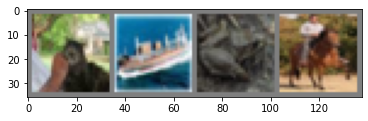

  cat  ship  frog horse


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### 定义卷积神经网络
之前从神经网络部分复制神经网络，然后对其进行修改以获取3通道图像（而不是定义的1通道图像）

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()


3. 定义损失函数和优化器
我们使用分类交叉熵损失和带有动量的SGD

In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. 训练网络

我们只需要遍历数据迭代器，然后将输入馈送到网络并进行优化即可

In [22]:
for epoch in range(2): #loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')


[1,  2000] loss: 2.212
[1,  4000] loss: 1.882
[1,  6000] loss: 1.680
[1,  8000] loss: 1.581
[1, 10000] loss: 1.527
[1, 12000] loss: 1.467
[2,  2000] loss: 1.428
[2,  4000] loss: 1.381
[2,  6000] loss: 1.355
[2,  8000] loss: 1.333
[2, 10000] loss: 1.298
[2, 12000] loss: 1.286
Finished Training


5. 快速保存我们训练过的模型

In [23]:
PATH = './cifar_net.pth'

torch.save(net.state_dict(), PATH)

6. 测试网络
我们已经在训练期间看到网络的性能，但我们需要检查是否已经学习了一些东西。

我们将通过训练神经网络输出的类别标签并根据实际情况进行检查，如果预测正确，则将样本添加到正确预测列表中。

让我们先显示测试集中的图像

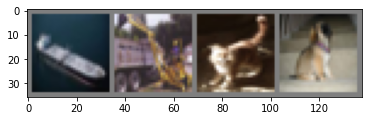

GroundTruth:   ship truck   cat   dog


In [24]:
datatier = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

让我们加载保存的模型

In [25]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

让我们检测一下训练网络的性能


In [26]:
from xml.etree.ElementPath import prepare_predicate


outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship   cat   dog   dog


让我们看一下网络再整个数据集上的表现·

In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 55 %


检查一下哪些类的表现良好，哪些类的表现不佳

In [28]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 58 %
Accuracy of   car : 71 %
Accuracy of  bird : 31 %
Accuracy of   cat : 40 %
Accuracy of  deer : 53 %
Accuracy of   dog : 51 %
Accuracy of  frog : 66 %
Accuracy of horse : 63 %
Accuracy of  ship : 63 %
Accuracy of truck : 56 %


在GPU上训练
就像将张量转移到GPU上一样，您也可以将神经网络转移到GPU上。
如果可以使用CUDA，首先将我们的设备定义为第一个可见的cuda设备


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


cuda:0


本节的其余部分假定device是CUDA设备

然后这些方法递归遍历所有模块并将其参数和缓冲区转换为CUDA张量

In [30]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

请记住，您还必须将每一步的输入和目标也发送到GPU上

In [31]:
inputs, labels = data[0].to(device), data[1].to(device)